In [114]:
import pandas as pd
import datetime as dt
from datetime import timedelta
from datetime import datetime
from numpy import random
from numpy import nan
import plotly.express as px


glob_random_state=100
random.seed(glob_random_state)
year=str('2019')

show_intermediate_results = True # False to not show graphs en example dataframes in this script; increased speed 
create_source_files = True # True to enable writing several dataframes to .CSV or .TSV files.

n_verkoop_order_df = 162 #random.randint(150,1500)
n_klant_df = 25 #random.randint(25,250)

In [115]:
dataframes_list = ['klant_df', 'verkoop_order_df', 'product_df', 'werkorder_df', 'machine_df',
                    'onderdelen_df', 'BOM_df', 'route_df']  

#  'woonplaatsen_df', 'achternamen_df',
# Removed from list. Only created as temporary results and deleted after join with klant_df

In [116]:
def create_dataframes(dataframes_list):
    for df in dataframes_list:
        vars()[df] = pd.DataFrame()

In [117]:
klant_df = pd.DataFrame(random.randint(0,100,size=(n_klant_df, 4)),  \
                        columns=['klant_id','klant_naam','klant_achternaam','klant_woonplaats'])
klant_df.index.rename('klant_id', inplace=True)


if show_intermediate_results == True:

    print(klant_df.head(10))

          klant_id  klant_naam  klant_achternaam  klant_woonplaats
klant_id                                                          
0                8          24                67                87
1               79          48                10                94
2               52          98                53                66
3               98          14                34                24
4               15          60                58                16
5                9          93                86                 2
6               27           4                31                 1
7               13          83                 4                91
8               59          67                 7                49
9               47          65                61                14


In [118]:
import xml.etree.ElementTree as et 

xtree = et.parse("fn_10kw.xml")
xroot = xtree.getroot()

df_columns=['achternaam', 'achternaam_los', 'voorvoegsel']
rows=[]

for node in xroot:
#     record = node.attrib.get("record")
#     naam = node.find("naam")  #.text if node is not None else None

    naam = ''
    achternaam_los = node.getchildren()[2].text if node is not None else None
    prefix = node.getchildren()[1].text if node is not None else None
    if prefix is not None:
        naam = achternaam_los+', '+prefix
    else: naam = achternaam_los
    
    rows.append({'achternaam':naam, 'achternaam_los':achternaam_los, 'voorvoegsel':prefix})

achternamen_df = pd.DataFrame(rows, columns=df_columns)
achternamen_df = achternamen_df.sample(len(klant_df))
achternamen_df.reset_index(inplace=True)
achternamen_df.index=klant_df['klant_achternaam']


voornamen_df = pd.read_csv('voornamen.txt', sep=';', skiprows=0, encoding='latin-1')
voornamen_df.columns=['geslacht','meet_jaar','maand','voornaam', 'rang']
voornamen_df = voornamen_df.sample(len(klant_df))
voornamen_df.reset_index(inplace=True)
voornamen_df.index=klant_df['klant_naam']


klant_df=klant_df.join(achternamen_df['achternaam'], on='klant_achternaam')
klant_df=klant_df.join(voornamen_df[['voornaam','geslacht']], on='klant_naam')
klant_df.drop(columns=['klant_achternaam','klant_naam'], inplace=True)
klant_df.drop_duplicates(subset=['klant_id','klant_woonplaats'], keep='first', inplace=True)

del voornamen_df, achternamen_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning:

This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.



In [119]:
woonplaatsen_df = pd.read_csv('Woonplaatsen_in_Nederland_2018_07042020_210926.csv', sep='";"', skiprows=3, encoding='UTF-8')
# Added , encoding='UTF-8' to prevent value 'Súdwest-Fryslân' in CSV being loaded as 'SÃºdwest-FryslÃ¢n'

woonplaatsen_df = woonplaatsen_df[1:]
new_column_names = list(woonplaatsen_df.columns)
new_column_names[0]='Woonplaats'
woonplaatsen_df.columns = new_column_names
 
woonplaatsen_df['Woonplaats'] = woonplaatsen_df['Woonplaats'].apply(lambda x: str(x).replace('"', '') )
woonplaatsen_df['Landsdeel|Code"'] = woonplaatsen_df['Landsdeel|Code"'].apply(lambda x: str(x).replace('"', '') )


# Take small sample of woonplaatsen_df and create new (incorrect) indexes (based on klant_df)
woonplaatsen_df=woonplaatsen_df.sample(len(klant_df))
woonplaatsen_df.reset_index(inplace=True)
woonplaatsen_df.index=klant_df['klant_woonplaats']


if show_intermediate_results == True:
    
    print(woonplaatsen_df.head(10) )

                  index      Woonplaats Gemeente|Naam  Gemeente|Code   \
klant_woonplaats                                                        
87                  192  Bergen op Zoom   BergenopZoom         GM0748   
94                 1993         Stokkum    Montferland         GM1955   
66                 1982        Stegeren          Ommen         GM0175   
24                  785       Heemstede      Heemstede         GM0397   
16                  891      Hoensbroek        Heerlen         GM0917   
2                  1770    Rinsumageast    Dantumadiel         GM1891   
1                   890      Hoenderloo            Ede         GM0228   
91                   83           Annen      AaenHunze         GM1680   
49                  196   Bergschenhoek  Lansingerland         GM1621   
14                  563      Everdingen         Vianen         GM0620   

                 Provincie|Naam Provincie|Code   Landsdeel|Naam  \
klant_woonplaats                                        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [120]:
klant_df=klant_df.join(woonplaatsen_df[['Woonplaats', 'Gemeente|Naam ', 'Gemeente|Code ', 'Provincie|Naam']],\
              on='klant_woonplaats')
klant_df.drop(columns=['klant_woonplaats'], inplace=True)
klant_df=klant_df[~klant_df.duplicated(subset=['klant_id','achternaam'], keep='first')]
del woonplaatsen_df
klant_df

,klant_id,achternaam,voornaam,geslacht,Woonplaats,Gemeente|Naam,Gemeente|Code,Provincie|Naam
klant_id,,,,,,,,
0,8,"Luijn, van",Noëlle,V,Bergen op Zoom,BergenopZoom,GM0748,Noord-Brabant
1,79,Oldenhuis,Feline,V,Stokkum,Montferland,GM1955,Gelderland
2,52,Li,Levi,M,Stegeren,Ommen,GM0175,Overijssel
3,98,"Avest, ter",Willem,M,Heemstede,Heemstede,GM0397,Noord-Holland
4,15,Selhorst,Nynke,V,Hoensbroek,Heerlen,GM0917,Limburg
5,9,Westers,Lara,V,Rinsumageast,Dantumadiel,GM1891,Friesland
6,27,Mourik,Stefan,M,Hoenderloo,Ede,GM0228,Gelderland
7,13,"Kesteren, van",Jeroen,M,Annen,AaenHunze,GM1680,Drenthe
8,59,Gomes,Job,M,Bergschenhoek,Lansingerland,GM1621,Zuid-Holland


In [121]:
# import modules
#import random
import datetime

# create function accepting a single parameter, the year as a four digit number
def get_random_date(year):
    
    calendar=pd.bdate_range(start='01-01-'+year, end='31-12-'+year)
    random_day=random.randint(0, 261)
    
    # try to get a date
    try:
#        return datetime.datetime.strptime('{} {}'.format(random.randint(1, 366), year), '%j %Y')
        return datetime.datetime.strptime(calendar[random_day].strftime('%Y-%m-%d') ,'%Y-%m-%d')

    # if the value happens to be in the leap year range, try again
    except ValueError:
        get_random_date(year)

In [122]:
verkoop_order_df = pd.DataFrame(data=(random.randint(0,25, size=(n_verkoop_order_df, 2))), columns=['klant_id','verkoop_order_datum'])
verkoop_order_df['verkoop_order_datum'] = verkoop_order_df['verkoop_order_datum'].apply(lambda x: get_random_date(year))
verkoop_order_df.sort_values(by='verkoop_order_datum', inplace=True)
verkoop_order_df.reset_index(drop=True, inplace=True)
verkoop_order_df.index.rename('verkoop_order_id', inplace=True)


if show_intermediate_results == True:
    print('n_verkoop_order_df : {}\n'.format(n_verkoop_order_df))
    print(verkoop_order_df.head(10))

n_verkoop_order_df : 162

                  klant_id verkoop_order_datum
verkoop_order_id                              
0                       21          2019-01-02
1                       14          2019-01-03
2                       18          2019-01-04
3                        5          2019-01-09
4                        3          2019-01-09
5                       20          2019-01-10
6                       20          2019-01-11
7                        8          2019-01-11
8                       19          2019-01-15
9                       19          2019-01-17


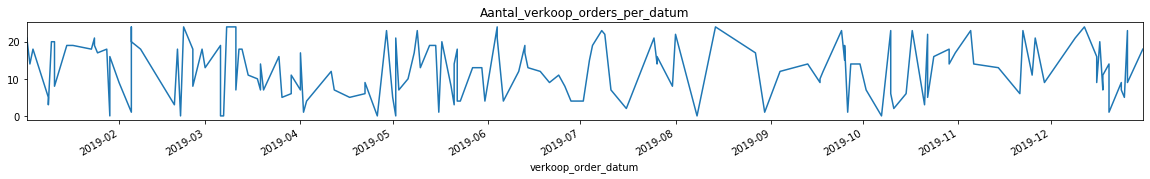

In [123]:
if show_intermediate_results == True:
    verkoop_order_df.plot(x='verkoop_order_datum', figsize=(20,2), legend=False, title='Aantal_verkoop_orders_per_datum', kind='line')

In [124]:
if show_intermediate_results == True:
#    verkoop_order_df.hist(column='klant_id', bins=10)
    fig=px.histogram(verkoop_order_df, x='verkoop_order_datum', nbins=12)
    fig.show()

In [125]:
if show_intermediate_results == True:
#    verkoop_order_df.hist(column='klant_id', bins=10)
    fig=px.histogram(verkoop_order_df, x='klant_id', nbins=10)
    fig.show()

In [126]:
product_verkoop_prijs_S, product_verkoop_prijs_M, product_verkoop_prijs_L = random.randint(50, 80, size=(3,1))
ratio_kp = 0.6

# Solve Issue #4 
product_data={                                             # Adding new product_id, requires to add bewerkingstijd() and BOM
 0:{'name':'Robot arm (S)',
    'revisie':'A',
    'kostprijs':float(product_verkoop_prijs_S),
    'verkoopprijs':float(product_verkoop_prijs_S*ratio_kp)},
 1:{'name':'Robot arm (M)',
    'revisie':'A',
    'kostprijs':float(product_verkoop_prijs_M),
    'verkoopprijs':float(product_verkoop_prijs_M*ratio_kp)},
 2:{'name':'Robot arm (L)',
    'revisie':'A',
    'kostprijs':float(product_verkoop_prijs_L),
    'verkoopprijs':float(product_verkoop_prijs_L*ratio_kp)},
 4:{'name':'Robot arm (L)',                                 # 'product_id' without a bill of material, for example purpose
    'revisie':'B',
    'kostprijs':float(product_verkoop_prijs_L),
    'verkoopprijs':float(product_verkoop_prijs_L*ratio_kp+17)},
3:{'name':'Robot arm (S)',
    'revisie':'B',
    'kostprijs':float(product_verkoop_prijs_S),
    'verkoopprijs':float(product_verkoop_prijs_S*ratio_kp+5)},
}


product_df = pd.DataFrame.from_dict(product_data, orient='index').reset_index()
product_df.columns = ['product_id','product_naam','revisie','product_verkoop_prijs','product_kost_prijs']

product_df.index.rename('product_id', inplace=True)
# product_df.drop('product_id', axis=1, inplace=True)

if show_intermediate_results == True:
    
    print(product_df.head(10) )

            product_id   product_naam revisie  product_verkoop_prijs  \
product_id                                                             
0                    0  Robot arm (S)       A                   62.0   
1                    1  Robot arm (M)       A                   77.0   
2                    2  Robot arm (L)       A                   66.0   
3                    4  Robot arm (L)       B                   66.0   
4                    3  Robot arm (S)       B                   62.0   

            product_kost_prijs  
product_id                      
0                         37.2  
1                         46.2  
2                         39.6  
3                         56.6  
4                         42.2  


In [127]:
# Solve issue #5
# # Opnieuw vullen van 'product_id' met de nieuwe id zoals ze gecreeerd zijn in product_df
# verkoop_order_df['product_id'] = verkoop_order_df['verkoop_order_datum'].apply(\
#                                                         lambda x: random.randint(0,len(product_df)))

In [128]:
"""7,27	2,53	5,82	2,02""".replace(',','.').replace('\t','\",\"')


'7.27","2.53","5.82","2.02'

In [129]:
def onderdelen():
    onderdeel_type=pd.DataFrame.from_dict({0:"Ruw Materiaal",\
                                           1:"Mechanisch",\
                                           2:"Electrisch"},\
                                         orient='index',\
                                         columns=['onderdeel_type_beschrijving'])
    onderdeel_type.index.rename('onderdeel_type_id', inplace=True)
    
    onderdelen=pd.DataFrame()
    columns=['onderdeel_id','onderdeel_naam','onderdeel_kostprijs',
             'onderdeel_type','onderdeel_gewicht_p_st_kg','materiaal_type',
             'virgin_gebruik_kg_CO2_p_kg','recycled_gebruik_kg_CO2_p_kg',
             'emissie_virgin_gebruik_kg_CO2','emissie_recycled_gebruik_kg_CO2']
    data= [[0,"Bout",0.002,1,0.144,"stainless steel 316","8.08","1.55","1.16","0.22"],
           [1,"Moer",0.002,1,0.017,"stainless steel 316","8.08","1.55","0.14","0.03"], 
           [2,"Schakelaar",3.075,2,0.852,"toggle switch","19.32","19.32","17.04","17.04"], 
           [3,"Sensor, controle",9.651,2,0,"onbekend","0","0","0","0"],   # TO ADD 
           [4,"Afdek kap plastic",1.003,0,0.340,"polypropylene","2.04","2.12","0.69","0.72"], 
           [5,"Staal frame",16.432,0,2.025,"stainless steel 316","8.00","2.00","16.36","3.14"],
           [6,"Afdek kap recycled plastic",6.103,0,0,"onbekend","0","0","0","0"], # TO ADD
           [7,"Aluminium frame", 16.231,0,0.800,"aluminium AMSQQA225B","7.27","2.53","5.82","2.02"], 
          ]
    onderdelen=pd.DataFrame(data=data, columns=columns)
    
    onderdelen=onderdelen.join(onderdeel_type, on='onderdeel_type')
    onderdelen.drop(columns=['onderdeel_type'], inplace=True)
    
    onderdelen['onderdeel_id'] = onderdelen['onderdeel_id'].apply(lambda x: x+1000 if x < 1000 else x)
    onderdelen.set_index(['onderdeel_id'], inplace=True)
    onderdelen.index.rename('onderdelen_id', inplace=True)
    
    return onderdelen

if show_intermediate_results == True:
    print(onderdelen())

                           onderdeel_naam  onderdeel_kostprijs  \
onderdelen_id                                                    
1000                                 Bout                0.002   
1001                                 Moer                0.002   
1002                           Schakelaar                3.075   
1003                     Sensor, controle                9.651   
1004                    Afdek kap plastic                1.003   
1005                          Staal frame               16.432   
1006           Afdek kap recycled plastic                6.103   
1007                      Aluminium frame               16.231   

               onderdeel_gewicht_p_st_kg        materiaal_type  \
onderdelen_id                                                    
1000                               0.144   stainless steel 316   
1001                               0.017   stainless steel 316   
1002                               0.852         toggle switch   
1003     

In [130]:
onderdelen_df=onderdelen()
onderdelen_df

,onderdeel_naam,onderdeel_kostprijs,onderdeel_gewicht_p_st_kg,materiaal_type,virgin_gebruik_kg_CO2_p_kg,recycled_gebruik_kg_CO2_p_kg,emissie_virgin_gebruik_kg_CO2,emissie_recycled_gebruik_kg_CO2,onderdeel_type_beschrijving
onderdelen_id,,,,,,,,,
1000,Bout,0.002,0.144,stainless steel 316,8.08,1.55,1.16,0.22,Mechanisch
1001,Moer,0.002,0.017,stainless steel 316,8.08,1.55,0.14,0.03,Mechanisch
1002,Schakelaar,3.075,0.852,toggle switch,19.32,19.32,17.04,17.04,Electrisch
1003,"Sensor, controle",9.651,0.000,onbekend,0,0,0,0,Electrisch
1004,Afdek kap plastic,1.003,0.340,polypropylene,2.04,2.12,0.69,0.72,Ruw Materiaal
1005,Staal frame,16.432,2.025,stainless steel 316,8.00,2.00,16.36,3.14,Ruw Materiaal
1006,Afdek kap recycled plastic,6.103,0.000,onbekend,0,0,0,0,Ruw Materiaal
1007,Aluminium frame,16.231,0.800,aluminium AMSQQA225B,7.27,2.53,5.82,2.02,Ruw Materiaal


In [131]:
def bill_of_materials(product_df):
    BOM=pd.DataFrame()
    columns=['product_id','product_revisie','BOM_lijn','BOM_hoeveelheid','BOM_eenheid','BOM_onderdeel_id_kind']

    data=[[0,'A', 0, 2, 'stuks', 0],
          [0,'A', 1, 2, 'stuks', 1],
          [0,'A', 2, 1, 'stuks', 2],
         # [0,'A', 3, 1, 'stuks', 3],   # Removed with intention 
          [0,'A', 4, 4, 'stuks', 4],
          [0,'A', 5, 1, 'stuks', 5],

          [1,'A', 0, 2, 'stuks', 0],
          [1,'A', 1, 2, 'stuks', 1],
          [1,'A', 2, 1, 'stuks', 2],
          [1,'A', 3, 1, 'stuks', 3],
          [1,'A', 4, 4, 'stuks', 4],
          [1,'A', 5, 1, 'stuks', 5], 
         
          [2,'A', 0, 2, 'stuks', 0],
          [2,'A', 1, 2, 'stuks', 1],
          [2,'A', 2, 1, 'stuks', 2],
          [2,'A', 3, 4, 'stuks', 3],
          [2,'A', 4, 12, 'stuks', 4],
          [2,'A', 5, 2, 'stuks', 5],
         
          [3,'B', 0, 2, 'stuks', 0],  # Updated revision on same product as product_id = 0
          [3,'B', 1, 2, 'stuks', 1],
          [3,'B', 2, 1, 'stuks', 2],
          [3,'B', 3, 1, 'stuks', 3],  # BOM_lijn #3 added     
          [3,'B', 4, 4, 'stuks', 6],  # Replaced with onderdeel #6 Afdek kap recylced plastic
          [3,'B', 5, 1, 'stuks', 5]]
    
    BOM=pd.DataFrame(data=data, columns=columns)
    
    # Just create an empty 'BOM_id' if a product_id is given that has no BOM lines defined
    products=list(product_df.index)
    for val in products:
        if val not in BOM['product_id'].unique():
            BOM=BOM.append(dict(zip(columns,[val,None,'','',None,''])),ignore_index=True)

#     # Convert ID's from floats to integers
#     BOM=BOM.dropna().select_dtypes(include=['float64']).astype('int16', copy=False)
#     # just don't use np.nan on integer columns to prevent them being converted to float...

    BOM.dropna(axis=0, how='any', inplace=True)
    BOM['BOM_onderdeel_id_kind'].astype('int64')
    BOM['BOM_onderdeel_id_kind']=BOM['BOM_onderdeel_id_kind'].apply(lambda x: x+1000 if x < 1000 else x)

    BOM.index.rename('BOM_id', inplace=True)

    
    return BOM


if show_intermediate_results == True:
    print(bill_of_materials(product_df))

        product_id product_revisie BOM_lijn BOM_hoeveelheid BOM_eenheid  \
BOM_id                                                                    
0                0               A        0               2       stuks   
1                0               A        1               2       stuks   
2                0               A        2               1       stuks   
3                0               A        4               4       stuks   
4                0               A        5               1       stuks   
5                1               A        0               2       stuks   
6                1               A        1               2       stuks   
7                1               A        2               1       stuks   
8                1               A        3               1       stuks   
9                1               A        4               4       stuks   
10               1               A        5               1       stuks   
11               2       

In [132]:
BOM_df=bill_of_materials(product_df)

In [133]:
def verkoop_order_product_map(verkoop_order_datum, product_df, year=year): #, glob_random_state=glob_random_state):
    product_df=product_df[['product_id', 'product_naam', 'revisie']]
    
    # find the minimum revision per product_naam
    idx = product_df.groupby(['product_naam'])['revisie'].transform(min) == product_df['revisie']
    prod_df_rev_min=product_df[idx].copy()
    
    # and the max/highest revision
    idx = product_df.groupby(['product_naam'])['revisie'].transform(max) == product_df['revisie']
    prod_df_rev_max=product_df[idx].copy()
    
    if type(verkoop_order_datum) != str:
        if type(verkoop_order_datum) != datetime.datetime:
            verkoop_order_datum = str(datetime.datetime.strptime(verkoop_order_datum.strftime('%Y-%m-%d') ,'%Y-%m-%d'))
    
    if verkoop_order_datum < year+'-08-01':
        verkocht_product_id=prod_df_rev_min.sample(1) #, random_state=glob_random_state)
    else: 
        verkocht_product_id=prod_df_rev_max.sample(1)

   
    return int(verkocht_product_id['product_id'])

if show_intermediate_results == True:
    for verkoop_order_datum in ['2019-01-03','2019-04-03','2019-07-03','2019-08-03','2019-09-03','2019-10-03']:
        prod=verkoop_order_product_map(verkoop_order_datum, product_df, year)
        print(verkoop_order_datum,'\t: ',prod,'\tRev :  ',product_df.iloc[prod]['revisie'],'\n')

2019-01-03 	:  2 	Rev :   A 

2019-04-03 	:  2 	Rev :   A 

2019-07-03 	:  0 	Rev :   A 

2019-08-03 	:  3 	Rev :   B 

2019-09-03 	:  3 	Rev :   B 

2019-10-03 	:  4 	Rev :   B 



In [134]:
verkoop_order_df['verkocht_product_id'] = verkoop_order_df['verkoop_order_datum'].apply(\
                                                        lambda x: verkoop_order_product_map(x,\
                                                                                            product_df, year=year))

verkoop_order_df['verkocht_product_aantal'] = 1

if show_intermediate_results == True:
    print(verkoop_order_df)

                  klant_id verkoop_order_datum  verkocht_product_id  \
verkoop_order_id                                                      
0                       21          2019-01-02                    0   
1                       14          2019-01-03                    2   
2                       18          2019-01-04                    1   
3                        5          2019-01-09                    2   
4                        3          2019-01-09                    2   
...                    ...                 ...                  ...   
157                      7          2019-12-24                    4   
158                      5          2019-12-25                    4   
159                     23          2019-12-26                    4   
160                      9          2019-12-26                    3   
161                     18          2019-12-31                    4   

                  verkocht_product_aantal  
verkoop_order_id                

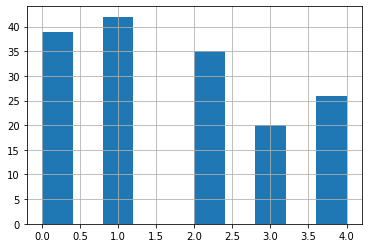

In [135]:
# verkoop_order_df['product_id'] = verkoop_order_df['verkoop_order_datum'].apply(lambda x: random.randint(0,3))


if show_intermediate_results == True:
    verkoop_order_df['verkocht_product_id'].hist()

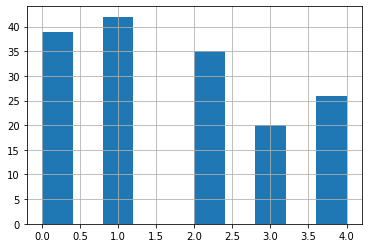

In [136]:
# verkoop_order_df['product_id'] = verkoop_order_df['verkoop_order_datum'].apply(lambda x: random.randint(0,3))
# Solve Issue #5

if show_intermediate_results == True:
    verkoop_order_df['verkocht_product_id'].hist()

In [137]:
machine_data ={
    # for issue #14 added energie_verbruik
    0:{'machine_type':'boor'},
    1:{'machine_type':'frees'},
    2:{'machine_type':'buig'},
    3:{'machine_type':'CNC'},
    4:{'machine_type':'snij'},
    5:{'machine_type':'boor'},
    6:{'machine_type':'stans'},
    7:{'machine_type':'CNC'},
    8:{'machine_type':'snij'},
    9:{'machine_type':'CNC'},
    10:{'machine_type':'CNC'},
    11:{'machine_type':'CNC'},
    12:{'machine_type':'boor'},
    13:{'machine_type':'assemblage'}   # abuse machine object to add an assembly step for issue #13
    }
machine_df = pd.DataFrame.from_dict(machine_data, orient='index').reset_index()
machine_df.columns = ['machine_id','machine_type']


machine_df.index.rename('machine_id', inplace=True)


if show_intermediate_results == True:
    
    print(machine_df.head(10) )

            machine_id machine_type
machine_id                         
0                    0         boor
1                    1        frees
2                    2         buig
3                    3          CNC
4                    4         snij
5                    5         boor
6                    6        stans
7                    7          CNC
8                    8         snij
9                    9          CNC


In [138]:
# werkorder_df = pd.DataFrame(data=(random.randint(0,25, size=(n_verkoop_order_df, 2))), columns=['klant_id','verkoop_order_datum'])
werkorder_df = verkoop_order_df.copy()
werkorder_df.reset_index(inplace = True)
werkorder_df.index.rename('werkorder_id', inplace=True)
werkorder_df['werkorder_start_datum'] = werkorder_df['verkoop_order_datum'].apply(lambda x: x+timedelta(days=random.randint(0,2)))
werkorder_df['werkorder_eind_datum'] = werkorder_df['verkoop_order_datum'].apply(lambda x: x+timedelta(days=random.randint(3,10)))


werkorder_df.drop(['klant_id','verkoop_order_datum'], axis=1, inplace=True)

if show_intermediate_results == True:
    print('n_werkorder_df : {}\n'.format(len(werkorder_df)))
    print(werkorder_df.head(10))

n_werkorder_df : 162

              verkoop_order_id  verkocht_product_id  verkocht_product_aantal  \
werkorder_id                                                                   
0                            0                    0                        1   
1                            1                    2                        1   
2                            2                    1                        1   
3                            3                    2                        1   
4                            4                    2                        1   
5                            5                    0                        1   
6                            6                    1                        1   
7                            7                    0                        1   
8                            8                    0                        1   
9                            9                    0                        1   

             werk

In [139]:
# Map products with a randaom amount of machines using both dataframes

def product_machines_map(product_df, machine_df):
    dictionary={}
    inner_dict={}
    machine_types=machine_df.machine_type.unique()
    machine_types=list(machine_types)[::-1]
    machine_types=['stans', 'snij', 'buig', 'frees', 'CNC', 'boor']
    print('\nHard code machine types and order: {}\n'.format(machine_types))
    product_ids=list(product_df.product_id.unique())
    step=0
    
    for prod_id in product_ids:
        low=random.randint(0,2)
        high=random.randint(4,6)
 #       print(high)
        for step in range(low,high):
            inner_dict[step]=machine_types[step]
        # add assemblage step (as a 'machine') in the mapping for issue #13
        inner_dict[len(inner_dict.keys())]='assemblage'
        dictionary[prod_id]=inner_dict
        inner_dict={}
    
    return dictionary

if show_intermediate_results == True:
    print(product_machines_map(product_df, machine_df))


Hard code machine types and order: ['stans', 'snij', 'buig', 'frees', 'CNC', 'boor']

{0: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'assemblage'}, 1: {1: 'snij', 2: 'buig', 3: 'assemblage'}, 2: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'}, 4: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'}, 3: {1: 'snij', 2: 'buig', 3: 'assemblage'}}


In [140]:
product_machines_map(product_df, machine_df)


Hard code machine types and order: ['stans', 'snij', 'buig', 'frees', 'CNC', 'boor']



{0: {1: 'snij', 2: 'buig', 3: 'frees', 4: 'assemblage'},
 1: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'assemblage'},
 2: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'},
 4: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'},
 3: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'}}

In [141]:
def zipper(l1, l2):
    return [list(l) for l in zip(l1, l2)]

In [142]:
def pick_random_machine(machine_type, machine_df):
    machine_id=0
    
    rand_pick=machine_df[machine_df['machine_type'] == machine_type]['machine_id']
    machine_id=rand_pick.iloc[random.randint(0, len(rand_pick))]
    
    return machine_id

# machine_df.sort_values('machine_type')

In [143]:
def bewerkingstijd(product_id, machine_id):
    bewerking_tijd = 1.3
    
    producten=list(product_df.index)
    machines=list(machine_df.index)
#    machines=list(machine_df.sort_values('machine_type').index)
    
#    matrix=random.randint(low=1, high=10, size=(len(producten), len(machines)))
    # added additional column for issue #13 to extend matrix object
    matrix=[[4, 9, 2, 9, 8, 8, 5, 15, 6, 12, 8, 6, 2, 15],
            [3, 8, 1, 11, 5, 2, 4, 13, 3, 15, 6, 7, 2, 14],
            [2, 6, 1, 12, 9, 7, 5, 16, 8, 16, 5, 4, 4, 13],
            [3, 7, 1, 10, 5, 2, 4, 13, 3, 16, 6, 7, 2, 10],
            [3, 8, 1, 11, 5, 2, 5, 16, 8, 16, 5, 4, 4, 9]]
    
    df=pd.DataFrame(data=matrix, columns=machines)

    bewerking_tijd=df[machine_id].iloc[product_id]
    
    return round(bewerking_tijd)

if show_intermediate_results == True:
    n,i =(1,4)
    print('\nproduct_id: {}\t machine_id: {}\n'.format(list(product_df.index)[n], list(machine_df.index)[i]))
    print(bewerkingstijd(list(product_df.index)[n], list(machine_df.index)[i]))


product_id: 1	 machine_id: 4

5


In [144]:
def insert_row_in_df(row_number, df, row_value):
    if row_number > df.index.max()+1: 
        print("Invalid row_number. Did not insert row into dataframe.")
        df_result=df
    else:
        # Slice the upper half of the dataframe 
        df1 = df[0:row_number] 

        # Store the result of lower half of the dataframe 
        df2 = df[row_number:] 

        # Inser the row in the upper half dataframe 
        df1.loc[row_number]=row_value 

        # Concat the two dataframes 
        df_result = pd.concat([df1, df2]) 

        # Reassign the index labels 
        df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 

In [153]:
def create_routes(werkorder_df, machine_df):
    columns=['werkorder_id','machine_id','step_id','bewerking_tijd']
    routes=pd.DataFrame(columns=columns)
    prod_machi_map=product_machines_map(product_df, machine_df)
    
    step=0
    machine='-'
    bewerking_tijd=1
    
    for wo in list(werkorder_df.index):
        
        # select a product_id for a given werkorder wo
        p=werkorder_df.iloc[wo]['verkocht_product_id'] # solve Issue #5 product_id
        
        # per step in the available steps/'keys' of a product
        for step in prod_machi_map[p].keys():
            
            # return the machine_id based on the machine_type
            
            # for issue #13. But don't use 'assemblage' to pick as random machine
            #   Temp remove 'assemblage' step from machine object 
            if prod_machi_map[p][step] != 'assemblage':
                machine=pick_random_machine(prod_machi_map[p][step], machine_df) 

            # for issue #13. Use only single existing 'machine' for 'assemblage' step
            else: machine=machine_df[machine_df['machine_type'] == 'assemblage']['machine_id'].values[0]
            
            bewerking_tijd=bewerkingstijd(p,machine)
            routes=routes.append(dict(zipper(columns, [wo, machine, step, bewerking_tijd])), ignore_index=True)
        
        # add another step for assembly at the end of a route dictionary
    
    routes.index.rename('route_step_id', inplace=True)

    
    return routes
    
# df=create_routes(werkorder_df[:20], machine_df)
# df.head(20)

In [154]:
def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

In [155]:
route_df = create_routes(werkorder_df, machine_df)
route_df['bewerking_tijd_cumsum'] = route_df[['werkorder_id', 'step_id','bewerking_tijd']].groupby(['werkorder_id', 'step_id'], \
                                                     sort=True).sum().groupby(level=0).cumsum().reset_index(inplace=False)['bewerking_tijd']
route_df['bewerking_tijd_cumsum_timedelta'] = route_df['bewerking_tijd_cumsum'].apply(lambda x: x)

if show_intermediate_results == True:
    print(route_df.head(30))


Hard code machine types and order: ['stans', 'snij', 'buig', 'frees', 'CNC', 'boor']

              werkorder_id machine_id step_id bewerking_tijd  \
route_step_id                                                  
0                        0          6       0              5   
1                        0          4       1              8   
2                        0          2       2              2   
3                        0          1       3              9   
4                        0         13       4             15   
5                        1          6       0              5   
6                        1          4       1              9   
7                        1          2       2              1   
8                        1          1       3              6   
9                        1          7       4             16   
10                       1         13       5             13   
11                       2          6       0              4   
12               



		Werkorder doorloop tijd



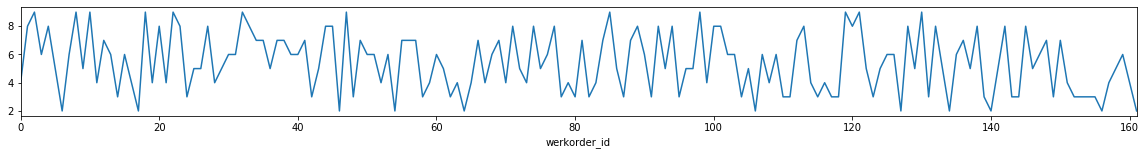

In [156]:
werkorder_df['werkorder_doorlooptijd'] = werkorder_df['werkorder_eind_datum']-werkorder_df['werkorder_start_datum']
# corrected to bypass Timestamps not being usefull in Power BI. Issue #2
werkorder_df['werkorder_doorlooptijd'] = werkorder_df['werkorder_doorlooptijd'].apply(lambda x: x.days)
werkorder_df['werkorder_maand_nummer'] = werkorder_df['werkorder_eind_datum'].apply(lambda x: x.isocalendar()[2])
werkorder_df['werkorder_doorlooptijd'].plot(figsize=(20,2))



print('\n\n\t\tWerkorder doorloop tijd\n')
#werkorder_df.drop(labels=['werkorder_doorlooptijd'], axis=1, inplace=True)

In [157]:
fig = px.line(werkorder_df.sort_values("werkorder_doorlooptijd", ascending=False),  y="werkorder_doorlooptijd", color='werkorder_maand_nummer')
fig.show()

In [158]:
klant__verkoop_order_df = klant_df.join(verkoop_order_df.set_index('klant_id'), lsuffix='le_', rsuffix='re_')

if show_intermediate_results == True:    
    print(klant__verkoop_order_df.head(8))

          klant_id  achternaam voornaam geslacht      Woonplaats  \
klant_id                                                           
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   

         Gemeente|Naam  Gemeente|Code  Provincie|Naam verkoop_order_datum  \
klant_id                                                                    
0          BergenopZoom         GM0748  Noord-Brabant          2019-01-29   
0          BergenopZoom         GM0748  Noord-Brabant          2019-02-21   
0          

In [159]:
def save_dateframes(dataframes_list):
    
    for df in dataframes_list:
        # Solving issue #7
        try:
            if globals()[df].index.name == None:
                old=globals()[df].index.name
                globals()[df].index.name=str(df).replace('_df', '')+'_id'
                print('{} >> {}'.format(old, globals()[df].index.name ))
        except: 
            print('Unable to change index column name for dataframe {}.'.format(df))

                
        try:
            
            globals()[df].to_csv(path_or_buf=str(df)+'.csv', sep='|')
            globals()[df].to_csv(path_or_buf=str(df)+'.tsv', sep='\t')
        except:
            print('Failed to save {} to TSV file.'.format(df))

In [160]:
if create_source_files:
    save_dateframes(dataframes_list)